In [108]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs/src/master/

fatal: destination path 'master' already exists and is not an empty directory.


In [109]:
!ls master

signnames.csv  test.p  train.p	valid.p


In [110]:
import numpy as np
import pickle
import requests
import random
import cv2
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten,Conv2D, MaxPooling2D

In [145]:
np.random.seed(0)

In [190]:
with open('master/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('master/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('master/test.p', 'rb') as f:
    test_data = pickle.load(f)

X_train, y_train = train_data['features'] ,  train_data['labels']
X_val, y_val = val_data['features'] ,  val_data['labels']
X_test, y_test = test_data['features'] ,  test_data['labels']

In [191]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [148]:
assert(X_train.shape[0] == y_train.shape[0]) , "The number of images is not same as the number of the lables"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not same as the number of the labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not same as the number of labels"
assert(X_train.shape[1:] == (32,32,3)), "The dimension of the images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32,32,3)), "The dimension of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32,32,3)), "The dimension of the images are not 32 x 32 x 3"

In [177]:
data = pd.read_csv('master/signnames.csv')

In [178]:
data.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


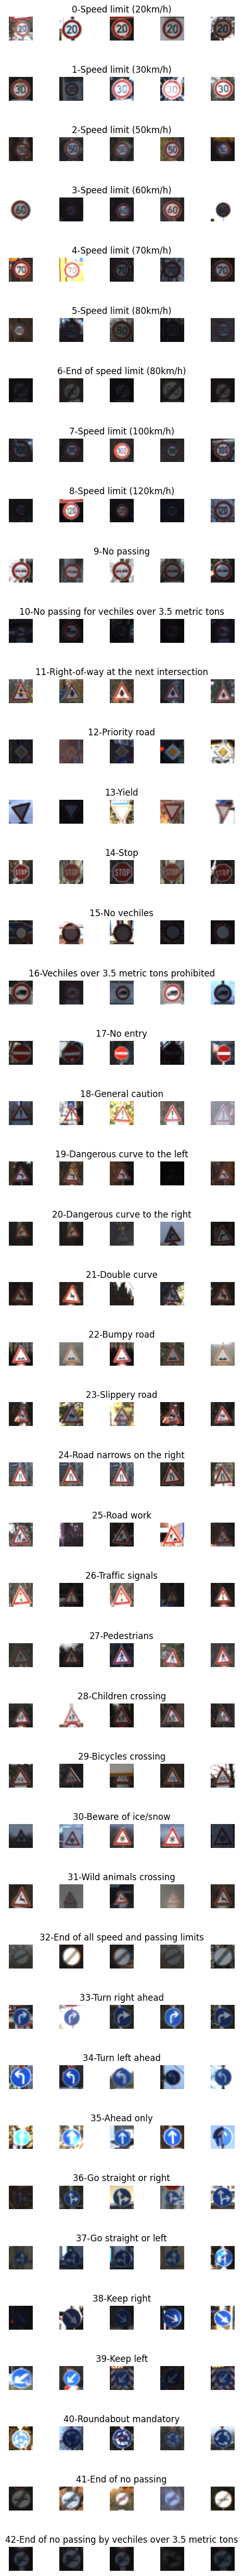

In [119]:
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row['SignName'])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

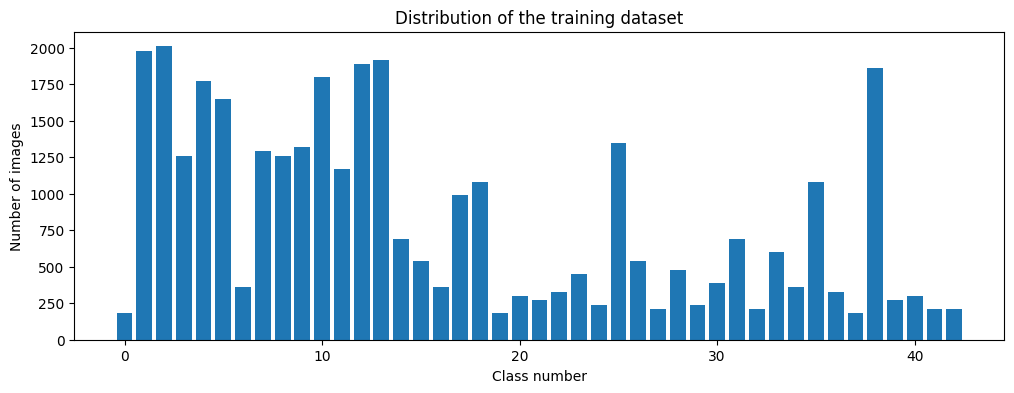

In [120]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
36


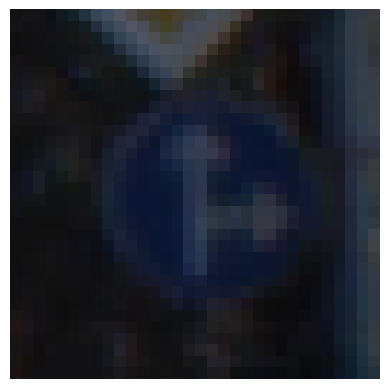

In [121]:
plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

In [192]:
def preprocessing(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.equalizeHist(img)
  img = img / 255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


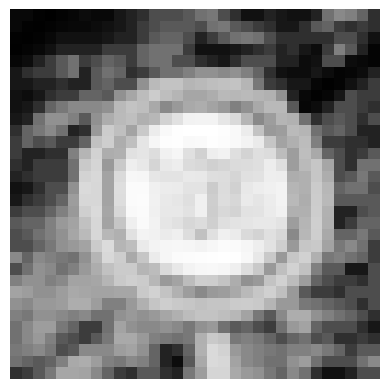

In [123]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)],cmap = 'gray')
plt.axis('off')
print(X_train.shape)

In [193]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [194]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(width_shift_range = 0.1,
                   height_shift_range = 0.1 ,
                   zoom_range = 0.2,
                   shear_range = 0.1,
                   rotation_range = 10 )
data_gen.fit(X_train)

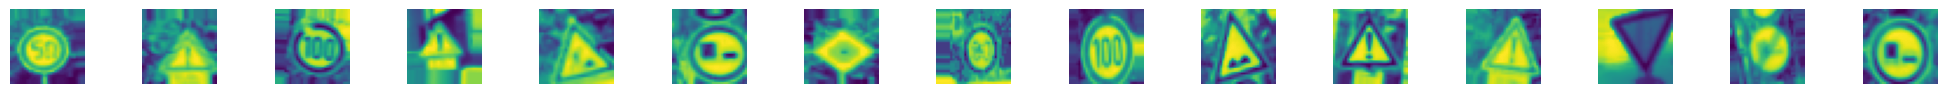

In [195]:
batches = data_gen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)
fig, axs = plt.subplots(1,15,figsize = (20, 5))
fig.tight_layout()
for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')

In [183]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [196]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [197]:
def modified_model():

  model = Sequential()
  model.add(Conv2D(60,(5,5), input_shape = (32,32,1), activation = 'relu'))
  model.add(Conv2D(60,(5,5), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))

  model.add(Conv2D(30,(3,3),activation = 'relu'))
  model.add(Conv2D(30,(3,3),activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))

  model.add(Flatten())
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(0.6))
  model.add(Dense(num_classes, activation ='softmax'))

  model.compile(Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [198]:
model = modified_model()
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)                   │ (None, 28, 28, 60)          │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 24, 24, 60)          │          90,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 12, 12, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 10, 10, 30)          │          16,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 8, 8, 30)            │           8,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │         123,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 250,167 (977.21 KB)

 Trainable params: 250,167 (977.21 KB)

 Non-trainable params: 0 (0.00 B)

In [199]:
history = model.fit(data_gen.flow(X_train, y_train, batch_size = 50), steps_per_epoch = 695, epochs = 10, validation_data = (X_val, y_val), shuffle =1)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.3378 - loss: 2.3983 - val_accuracy: 0.8658 - val_loss: 0.4692
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.7359 - loss: 0.8527 - val_accuracy: 0.9438 - val_loss: 0.1765
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8410 - loss: 0.5188 - val_accuracy: 0.9567 - val_loss: 0.1357
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8799 - loss: 0.3856 - val_accuracy: 0.9746 - val_loss: 0.1040
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9086 - loss: 0.2965 - val_accuracy: 0.9735 - val_loss: 0.0856
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9207 - loss: 0.2543 - val_accuracy: 0.9789 - val_loss: 0.0655
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9326 - loss: 0.2188 - val_accuracy: 0.9841 - val_loss: 0.0518
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9368 -

Text(0.5, 0, 'epochs')

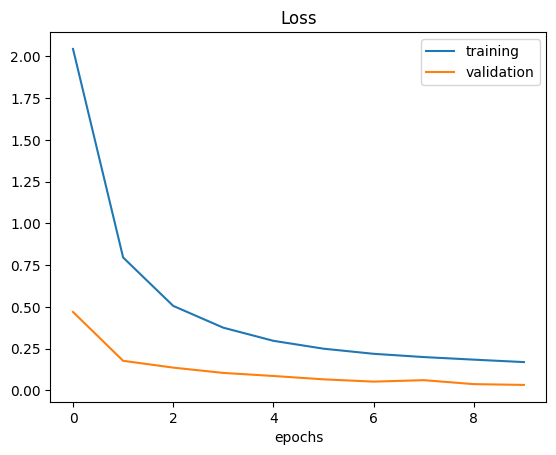

In [200]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

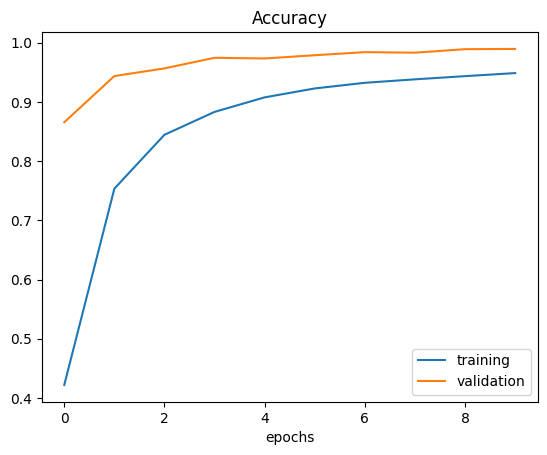

In [201]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epochs')

In [161]:
score = model.evaluate(X_test, y_test, verbose = 0)
print("Test score", score[0])
print("Test Accuracy", score[1])

Test score 0.13189156353473663
Test Accuracy 0.9660332798957825


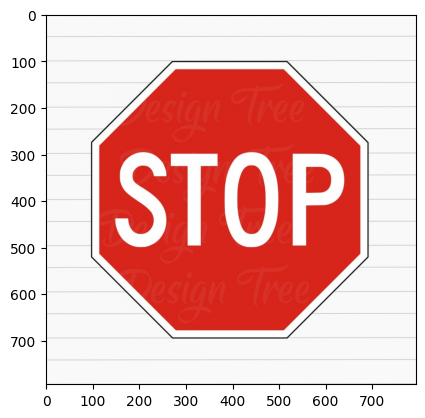

In [162]:
import requests
from PIL import Image
url = 'https://i.etsystatic.com/29364634/r/il/c9acb0/3817892362/il_794xN.3817892362_qdhi.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))


(32, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Predicted sign:  14


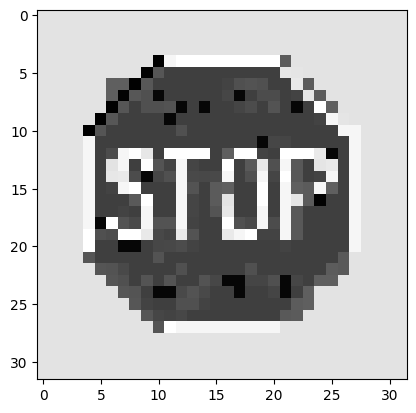

In [163]:
#Preprocess image
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

#Reshape reshape

img = img.reshape(1, 32, 32, 1)

#Test image
print("Predicted sign: " , model.predict(img).argmax(axis = 1)[0])